# Создание моделей для оценки коров

# Описание проекта
Заказчик - фермер владелец молочного хозяйства «Вольный луг». Он хочет купить бурёнок, чтобы расширить поголовье стада коров. Для этого он заключил выгодный контракт с ассоциацией пастбищ «ЭкоФерма».
Условия позволяют фермеру очень тщательно отобрать коров. Он определяет качество молока по строгой методике, и при этом ему нужно выполнять свой план развития молочного хозяйства. Фермер хочет, чтобы каждая бурёнка давала не менее 6000 килограммов молока в год, а её надой был вкусным — строго по его критериям, ничуть не хуже. А продавцы и технологи так и норовят приукрасить своих коровок!
Поэтому он просит вас разработать модель машинного обучения, которая поможет ему управлять рисками и принимать объективное решение о покупке. «ЭкоФерма» готова предоставить подробные данные о своих коровах. Необходимо создать две прогнозные модели для отбора бурёнок в поголовье:
* 1)Первая будет прогнозировать возможный удой коровы (целевой признак Удой);
* 2)Вторая — рассчитывать вероятность получить вкусное молоко от коровы (целевой признак Вкус молока).

С помощью модели нужно отобрать коров по двум критериям:
* средний удой за год — не менее 6000 килограммов;
* молоко должно быть вкусным.

## Описание данных
Файл ferma_main.csv содержит данные о стаде фермера на текущий момент:
* id — уникальный идентификатор коровы.
* Удой, кг — масса молока, которую корова даёт в год (в килограммах).
* ЭКЕ (Энергетическая кормовая единица) — показатель питательности корма коровы.
* Сырой протеин, г — содержание сырого протеина в корме (в граммах).
* СПО (Сахаро-протеиновое соотношение) — отношение сахара к протеину в корме коровы.
* Порода — порода коровы.
* Тип пастбища — ландшафт лугов, на которых паслась корова.
* порода папы_быка — по рода папы коровы.
* Жирность,% — содержание жиров в молоке (в процентах).
* Белок,% — содержание белков в молоке (в процентах).
* Вкус молока — оценка вкуса по личным критериям фермера, бинарный признак (вкусно, не вкусно).
* Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

Признаки в датасете ferma_main.csv можно разделить на группы.
Характеристики коровы: id, Порода, порода папы_быка, Возраст.
Характеристики корма: ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г, СПО (Сахаро-протеиновое соотношение).
Характеристика пастбища: Тип пастбища.
Характеристики молока: Удой, кг, Жирность,%, Белок,%, Вкус молока.

Файл ferma_dad.csv хранит имя папы каждой коровы в стаде фермера:
* id — уникальный идентификатор коровы.
* Имя Папы — имя папы коровы.

Файл cow_buy.csv — это данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой:
* Порода — порода коровы.
* Тип пастбища — ландшафт лугов, на которых паслась корова.
* порода папы_быка — порода папы коровы.
* Имя_папы — имя папы коровы.
* Текущая_жирность,% — содержание жиров в молоке (в процентах).
* Текущий_уровень_белок,% — содержание белков в молоке (в процентах).
* Возраст — возраст коровы, бинарный признак (менее_2_лет, более_2_лет).

In [1]:
!pip install phik

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LinearRegression
from  sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.utils import resample

## Загрузка и изучение данных

In [3]:
try:
    df_cow_buy = pd.read_csv("cow_buy.csv", sep=';', decimal=',')
    df_ferma_dad = pd.read_csv("ferma_dad.csv", sep=';', decimal=',')
    df_ferma_main = pd.read_csv("ferma_main.csv", sep=';', decimal=',')
except:
    df_cow_buy = pd.read_csv("/datasets/cow_buy.csv", sep=';', decimal=',')
    df_ferma_dad = pd.read_csv("/datasets/ferma_dad.csv", sep=';', decimal=',')
    df_ferma_main = pd.read_csv("/datasets/ferma_main.csv", sep=';', decimal=',')

In [4]:
df_cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


In [5]:
df_ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [6]:
df_ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

## Предобработка данных

Для начала изменим все названия столбцов на корректные

In [7]:
df_cow_buy.columns = ['breed', 'pasture_type', 'father_breed', 'father_name', 'current_fat', 'current_protein', 'age']
df_ferma_dad.columns = ['id','father_name']
df_ferma_main.columns = ['id', 'milk_amount', 'efu', 'crude_protein', 'spa', 'breed', 'pasture_type', 'father_breed', 'current_fat', 'current_protein','milk_taste', 'age']

Теперь рассмотрим каждый датасет по отдельности

In [8]:
df_cow_buy.head(10)

,breed,pasture_type,father_breed,father_name,current_fat,current_protein,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет


Рассмотрим наличие пропусков и дубликатов

In [9]:
print("Количество дубликатов = ", df_cow_buy.duplicated().sum())
print("Количество пропусков по столбцам равно ", df_cow_buy.isna().sum(), sep='\n')

Количество дубликатов =  4
Количество пропусков по столбцам равно 
breed              0
pasture_type       0
father_breed       0
father_name        0
current_fat        0
current_protein    0
age                0
dtype: int64


удалим явные дубликаты

In [10]:
df_cow_buy.drop_duplicates(inplace=True)

Напишем фунцию для отчистки выбросов

In [11]:
def outliers_cleaning(data, column_name, lower_bound=0, upper_bound=1):
    column = data[column_name]
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    if lower_bound == 0:
        lower_bound = Q1 - 1.5 * IQR
    if upper_bound == 1:
        upper_bound = Q3 + 1.5 * IQR
    checking_cleaned_data = data[((column >= lower_bound) & (column <= upper_bound)) | (column.isna())]
    outliers_part = 1 - checking_cleaned_data.shape[0] / data.shape[0]
    if outliers_part < 0.1:
        print(f"Доля выбросов в колонке {column_name} определяемых данным методом {round(outliers_part * 100, 2)}%, они были удалены")
        return checking_cleaned_data
    else:
        print(
            f"Доля выбросов в колонке {column_name} определяемых данным методом {round(outliers_part * 100, 2)}%, стоит попробовать другой способ")
        return data

In [12]:
df_ferma_dad

,id,father_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
...,...,...
624,625,Буйный
625,626,Барин
626,627,Барин
627,628,Барин


In [13]:
print("Количество дубликатов = ", df_ferma_dad.duplicated().sum())
print("Количество пропусков по столбцам равно ", df_ferma_dad.isna().sum(), sep='\n')

Количество дубликатов =  0
Количество пропусков по столбцам равно 
id             0
father_name    0
dtype: int64


ни пропусков ни дубликатов эту таблицу нам не изменить

In [14]:
df_ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               634 non-null    int64  
 1   milk_amount      634 non-null    int64  
 2   efu              634 non-null    float64
 3   crude_protein    634 non-null    int64  
 4   spa              634 non-null    float64
 5   breed            634 non-null    object 
 6   pasture_type     634 non-null    object 
 7   father_breed     634 non-null    object 
 8   current_fat      634 non-null    float64
 9   current_protein  634 non-null    float64
 10  milk_taste       634 non-null    object 
 11  age              634 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 59.6+ KB


In [15]:
print("Количество дубликатов = ", df_ferma_main.duplicated().sum())
print("Количество пропусков по столбцам равно ", df_ferma_main.isna().sum(), sep='\n')

Количество дубликатов =  5
Количество пропусков по столбцам равно 
id                 0
milk_amount        0
efu                0
crude_protein      0
spa                0
breed              0
pasture_type       0
father_breed       0
current_fat        0
current_protein    0
milk_taste         0
age                0
dtype: int64


удалим явные дубликаты

In [16]:
df_ferma_main.drop_duplicates(inplace=True)

посмотрим на наличие неявных дубликатов в категориальных признаках

In [17]:
for column in df_ferma_main.select_dtypes(include=['object']).columns:
    print(df_ferma_main[column].unique())

['Вис Бик Айдиал' 'РефлешнСоверинг']
['Равнинное' 'Равнинные' 'Холмистое']
['Айдиал' 'Соверин' 'Айдиалл']
['вкусно' 'не вкусно']
['более_2_лет' 'менее_2_лет']


избавимся от неявных дубликатов

In [18]:
df_ferma_main['pasture_type'].replace({'Равнинные' : 'Равнинное'}, inplace=True)
df_ferma_main['father_breed'].replace({'Айдиалл' : 'Айдиал'}, inplace=True)

Теперь удалим все выбросы

In [19]:
numeric_columns = ['current_fat', 'current_protein', 'spa', 'milk_amount', 'efu', 'crude_protein']
for column in numeric_columns:
    df_ferma_main = outliers_cleaning(df_ferma_main, column)
df_ferma_main.reset_index(drop=True)

Доля выбросов в колонке current_fat определяемых данным методом 13.83%, стоит попробовать другой способ
Доля выбросов в колонке current_protein определяемых данным методом 0.79%, они были удалены
Доля выбросов в колонке spa определяемых данным методом 0.0%, они были удалены
Доля выбросов в колонке milk_amount определяемых данным методом 0.16%, они были удалены
Доля выбросов в колонке efu определяемых данным методом 0.0%, они были удалены
Доля выбросов в колонке crude_protein определяемых данным методом 0.0%, они были удалены


,id,milk_amount,efu,crude_protein,spa,breed,pasture_type,father_breed,current_fat,current_protein,milk_taste,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет
...,...,...,...,...,...,...,...,...,...,...,...,...
618,625,6812,15.4,1964,0.940,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет
619,626,5513,12.9,1700,0.880,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет
620,627,5970,14.4,1837,0.880,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
621,628,5746,13.8,1994,0.890,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,вкусно,более_2_лет


In [20]:
df_ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 623 entries, 0 to 628
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               623 non-null    int64  
 1   milk_amount      623 non-null    int64  
 2   efu              623 non-null    float64
 3   crude_protein    623 non-null    int64  
 4   spa              623 non-null    float64
 5   breed            623 non-null    object 
 6   pasture_type     623 non-null    object 
 7   father_breed     623 non-null    object 
 8   current_fat      623 non-null    float64
 9   current_protein  623 non-null    float64
 10  milk_taste       623 non-null    object 
 11  age              623 non-null    object 
dtypes: float64(4), int64(3), object(5)
memory usage: 63.3+ KB


После удаления выбросов было удалено около 1% данных, я считаю такое количество не повлияет на итоговую модель

### Промежуточный выбор по предобработке
В ходе предобработки было рассмотрено 3 файла с данными, датасет с папами коров мы никак не изменили, в таблици с информацией о коровах на продажу было удалено 4 явных дубликата и в датасете с коровами фермера мы заменили неявные дубликаты и удалили около 1% выбросов.

## Исследовательский анализ данных

Напишем функцию для построения графика для числовых столбцов

In [21]:
from matplotlib.gridspec import GridSpec
def numeric_info(column, column_name):
    gs = GridSpec(1, 2, width_ratios=[5, 2], wspace=0.2, figure=plt.figure(figsize=(6, 5)))
    ax1 = plt.subplot(gs[0])
    column.plot.kde()
    ax1.set_title(f"Распределение столбца {column_name}")

    ax2 = plt.subplot(gs[1])
    text = column.describe().to_string()
    ax2.text(0, 0.5, text, ha='left', va='center', fontsize=12, linespacing=1.5)
    ax2.axis('off')
    plt.show()

Построим графики

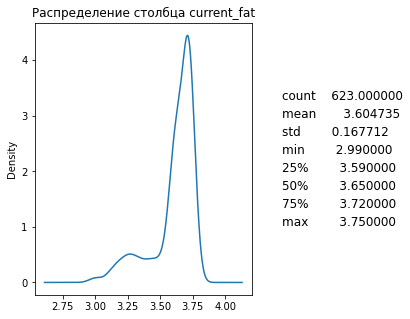

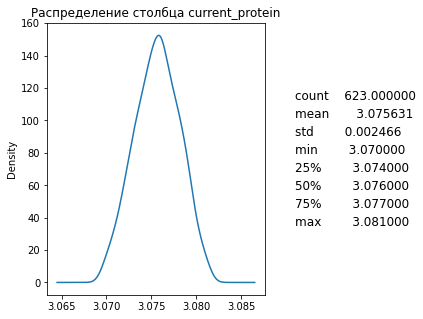

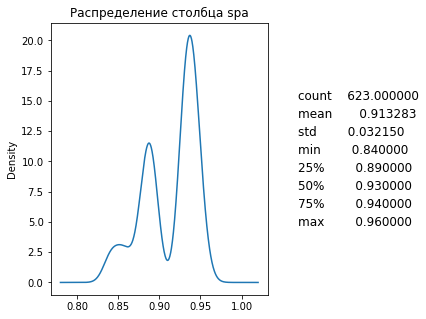

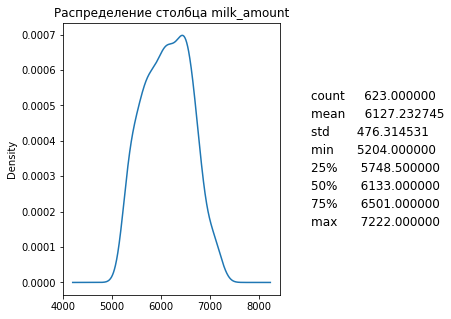

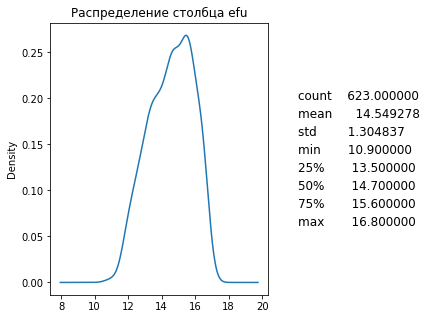

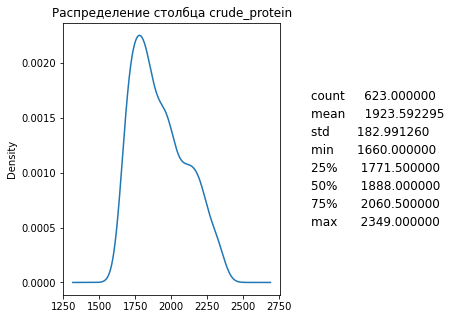

In [22]:
numeric_columns = ['current_fat', 'current_protein', 'spa', 'milk_amount', 'efu', 'crude_protein']
for column in numeric_columns:
    numeric_info(df_ferma_main[column], column)

График spa - мультимодальный на него надо будет обратить внимание при подготовке данных к моделированию, также небольшая проблема с current_fat, распределение же остальных примерно похоже на нормальное

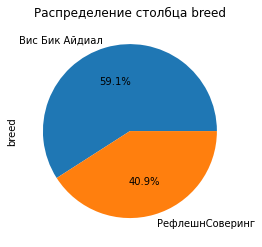

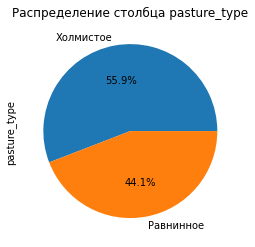

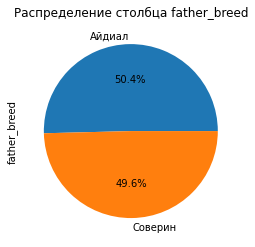

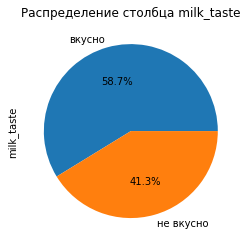

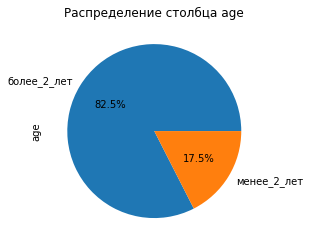

In [23]:
object_columns = ['breed', 'pasture_type', 'father_breed', 'milk_taste', 'age']
for column in object_columns:
    tmp_df = df_ferma_main[column].value_counts()
    tmp_df.plot.pie(autopct='%1.1f%%')
    plt.title(f"Распределение столбца {column}")
    plt.show()

Все категориальные признаки распределены примерно поровну, единсвенное исключение - возраст, большинство коров старше 2 лет.

### Промежуточный вывод по исследовательскому анализу
Распределение большинства числовых признаков примерно похоже на нормальное, только графики spa и current_fat - мультимодальный на них надо будет обратить внимание при подготовке данных к моделированию. Все категориальные признаки распределены примерно поровну, единственное исключение - возраст, большинство коров старше 2 лет.

## Корреляционный анализ

Посмотрим на матрицу корреляции

interval columns not set, guessing: ['id', 'milk_amount', 'efu', 'crude_protein', 'spa', 'current_fat', 'current_protein']


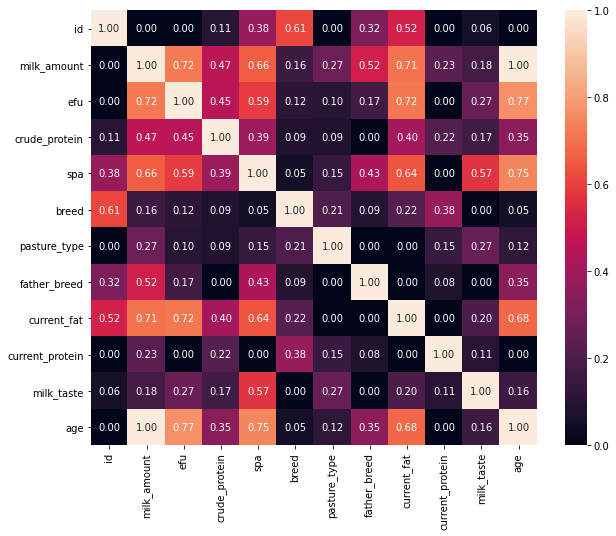

In [24]:
plt.figure(figsize=(10, 8))
c_m = df_ferma_main.phik_matrix()
sns.heatmap(c_m, annot=True, fmt='.2f');

In [25]:
connection = {"zero" : [], "weak" : [], "medium" : [], "notable" : [], "hight" : [], "very_hight" : []}
for name, correlation_coefficient in zip(c_m['milk_amount'].index, c_m['milk_amount']):
    if correlation_coefficient <= 0.1:
        connection["zero"].append(name)
    elif correlation_coefficient <= 0.3:
        connection["weak"].append(name)
    elif correlation_coefficient <= 0.5:
        connection["medium"].append(name)
    elif correlation_coefficient <= 0.7:
        connection["notable"].append(name)
    elif correlation_coefficient <= 0.9:
        connection["hight"].append(name)
    elif correlation_coefficient <= 1:
        connection["very_hight"].append(name)
print(json.dumps(connection, indent=4))

{
    "zero": [
        "id"
    ],
    "weak": [
        "breed",
        "pasture_type",
        "current_protein",
        "milk_taste"
    ],
    "medium": [
        "crude_protein"
    ],
    "notable": [
        "spa",
        "father_breed"
    ],
    "hight": [
        "efu",
        "current_fat"
    ],
    "very_hight": [
        "milk_amount",
        "age"
    ]
}


Видим, что при построении моделей будет необходимо обращать внимание на признаки age, efu, current_fat, spa, father_breed, crude_protein

Построим диаграммы рассеяния для всех признаков

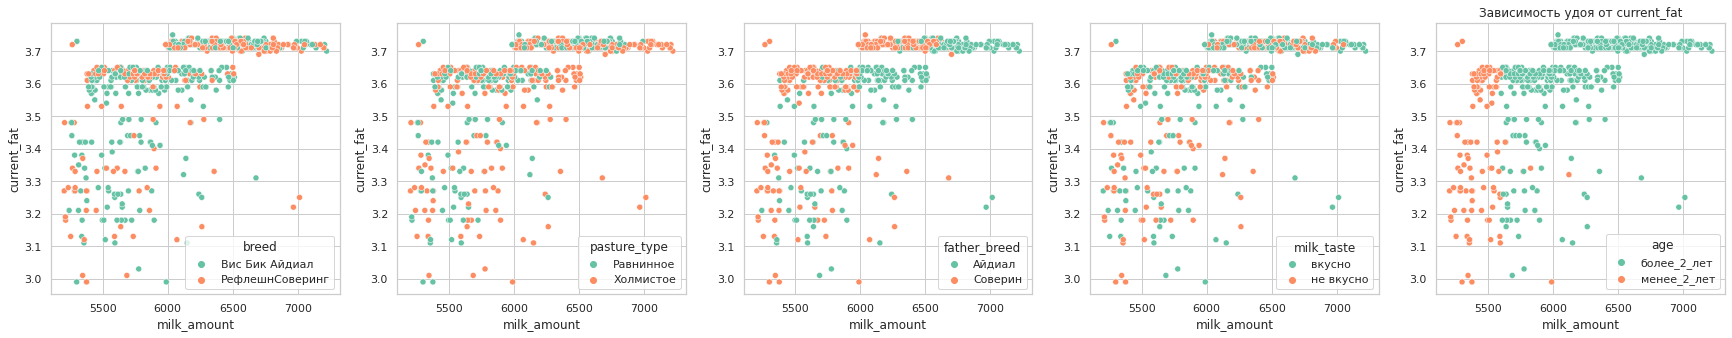

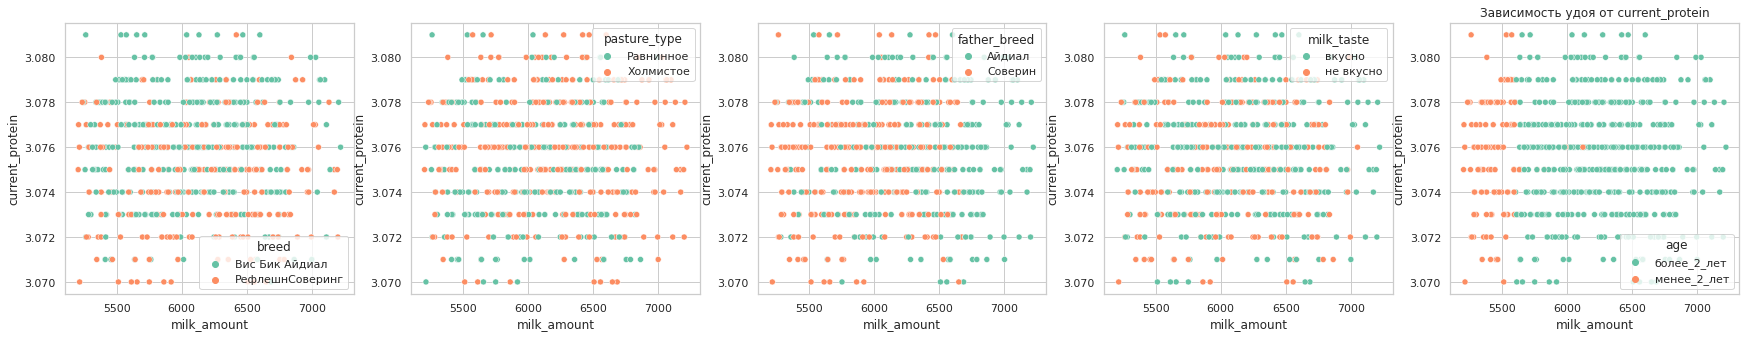

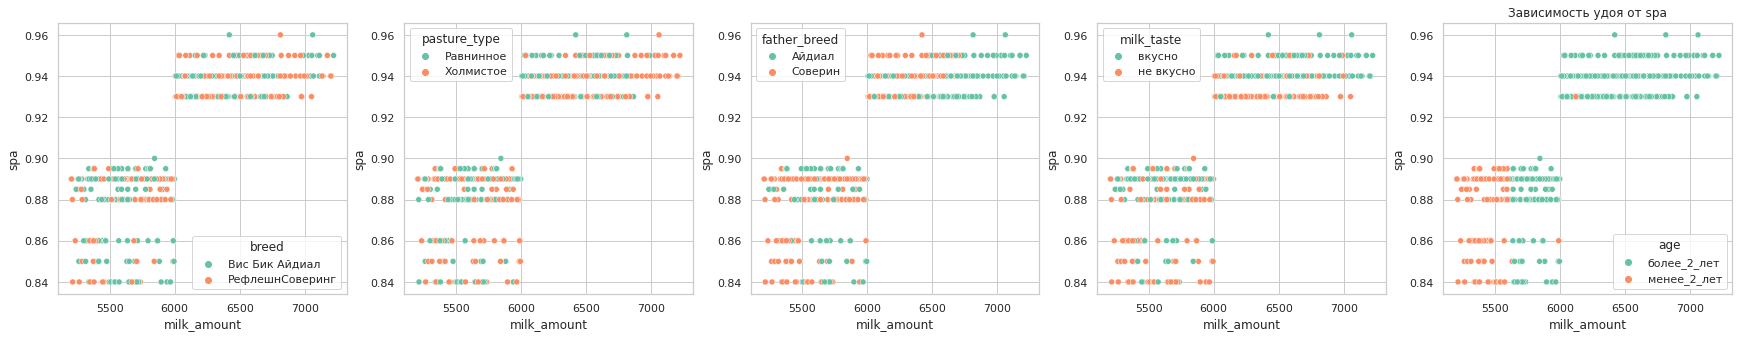

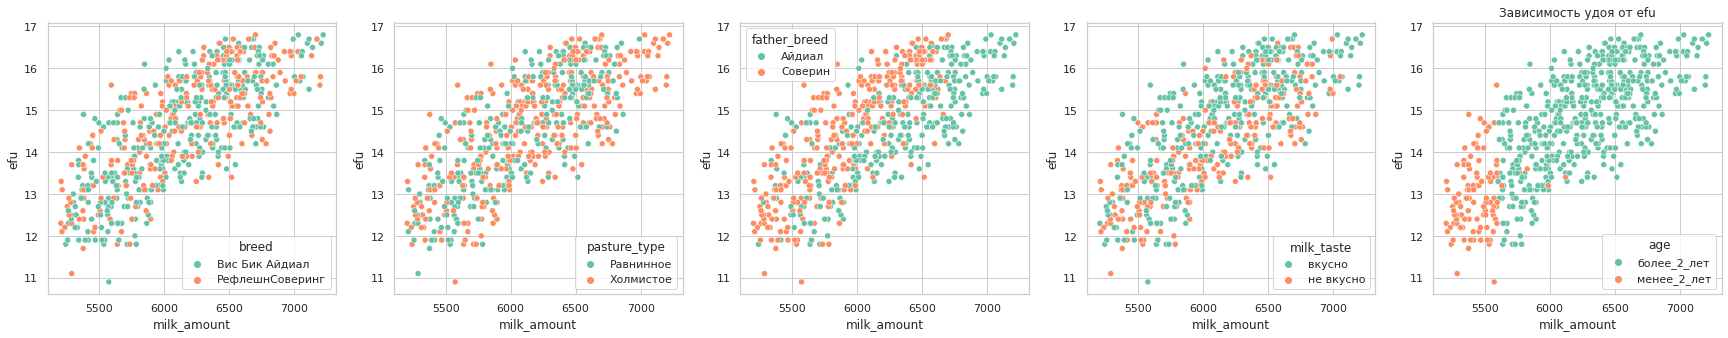

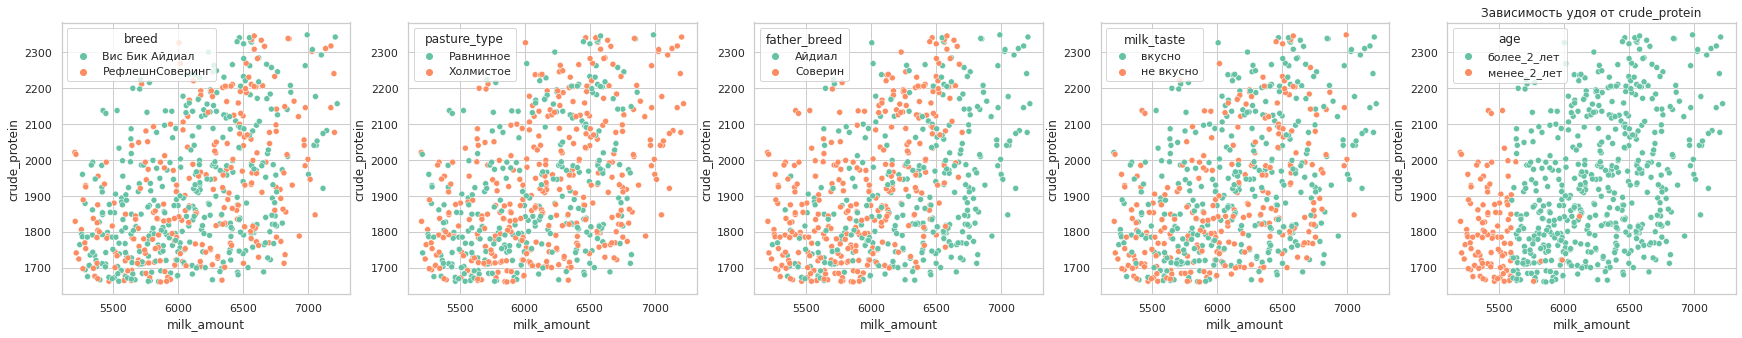

In [26]:
numeric_columns = ['current_fat', 'current_protein', 'spa', 'efu', 'crude_protein']
object_columns = ['breed', 'pasture_type', 'father_breed', 'milk_taste', 'age']
sns.set(style="whitegrid")

for numeric in numeric_columns:
    fig, axes = plt.subplots(nrows=1, ncols=len(object_columns), figsize=(30, 5))
    i = 0
    for string in object_columns:
        scatter_plot = sns.scatterplot(x='milk_amount', y=numeric, hue=string, data=df_ferma_main, palette='Set2', ax=axes[i])
        scatter_plot.legend(title=string)
        plt.title(f'Зависимость удоя от {numeric}')
        i += 1
    plt.show()

### Промежуточный вывод по корреляционному анализу
Видим, что хоть и некая линейная взаимосвязь между целевым признаком и некоторыми признаками присутствует, но судя по графикам линейной зависимости нет. Также видно пару любопытных особенностей: между efu и milk_amount есть чёткая связь, хоть и не линейная, количество молока от старых коров всегда больше, чем от молодых и порода Айдиал даёт больший удой чем Соверин. Признаки Current fat и spa оба разделились на 2 кластера, чем можно было бы воспользоваться превратив их в бинарные. Также была найдена мультиколлинеарность между входными признаками - current_fat, etu и spa сильно связаны между собой.

## Задача регрессии

In [27]:
models_score = [];

Напишем функцию для моделирования

In [28]:
def modeling(data, numeric_columns, object_columns):
    # Разделение на тренировочную и тестовую выборки
    data.drop('current_fat', axis=1) # РЕВЬЮЕР ПРОВЕРЯЕТ
    train_data, test_data = train_test_split(data, test_size=0.2, random_state=40)
    
    # Сброс индексов
    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)
    
    # Определение шагов преобразования для ColumnTransformer
    transformers = [
        ('numeric', StandardScaler(), numeric_columns),
        ('onehot', OneHotEncoder(drop='if_binary'), object_columns)
    ]
 
    # Создание ColumnTransformer с определенными шагами
    ct = ColumnTransformer(transformers, remainder='passthrough')
    
    # Преобразование тренировочной и тестовой выборок
    X_train_transformed = ct.fit_transform(train_data.drop(['milk_amount', 'milk_taste', 'id'], axis=1))
    X_test_transformed = ct.transform(test_data.drop(['milk_amount', 'milk_taste', 'id'], axis=1))
    
    # Достаем признаки и целевую переменную для обеих выборок
    y_train = train_data['milk_amount']
    y_test = test_data['milk_amount']
    
    # Обучение модели линейной регрессии
    model = LinearRegression()
    model.fit(X_train_transformed, y_train)
    
    # Проверим её на тестовой выборке
    predictions = model.predict(X_test_transformed)
    
    # Получение всех оценок
    r2 = r2_score(y_test, predictions)
    print('r2 = ', r2)
    mae = mean_absolute_error(y_test, predictions)
    print('mae = ', mae)
    mse = mean_squared_error(y_test, predictions)
    print('mse = ', mse)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    print('rmse = ', rmse)
    scores = [r2, mae, mse, rmse]
    
    # Получение доверительного интервала
    n_iterations = 1000
    results = []
    for _ in range(n_iterations):
        # Создание бутстреп-выборки
        X_sample, y_sample = resample(X_test_transformed, y_test)
        # Получение предсказаний модели на бутстреп-выборке
        predictions = model.predict(X_sample)
        # Оценка качества модели (например, среднеквадратичная ошибка)
        accuracy = r2_score(y_sample, predictions)
        # Сохранение оценки
        results.append(accuracy)
        
    # Вычисление доверительного интервала
    confidence_interval = np.percentile(results, [2.5, 97.5])
    print("95% доверительный интервал r2 : {:.2f} - {:.2f}".format(confidence_interval[0], confidence_interval[1]))
    
    #Проанализируем распределения остатков
    error = y_test - predictions
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(12,8))
    ax[0].hist(error)
    ax[1].scatter(y=error, x=y_test)
    plt.show()
    return scores, model

r2 =  0.7941502041759654
mae =  173.68457544582003
mse =  47535.998808771576
rmse =  218.02751846675588
95% доверительный интервал r2 : 0.73 - 0.84


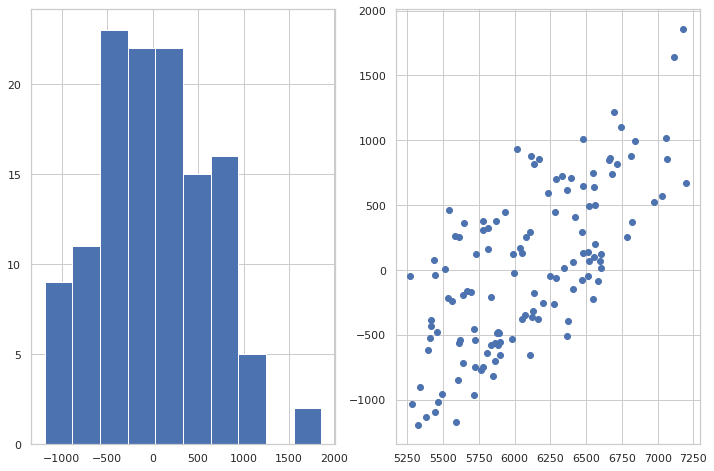

In [29]:
numeric_columns = ['current_fat', 'current_protein', 'spa', 'efu', 'crude_protein']
object_columns = ['breed', 'pasture_type', 'father_breed', 'age']
scores, regression_model = modeling(df_ferma_main, numeric_columns, object_columns)
models_score.append(scores)

79% изменчивости целевой величины мы смогли объяснить этой моделью, это неплохой результат, но к сожалению видим проблемы с распределением остатков - неслучайная дисперсия. Теперь попробуем немного видоизменить входные данные.

Как было замечено ранее признак spa разделен по кластерам, попробуем превратить его в категориальный, для этого рассмотрим его графики

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


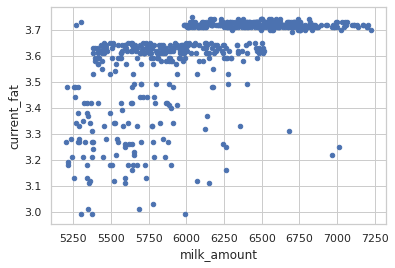

In [30]:
df_ferma_main.plot.scatter(y='current_fat', x='milk_amount');

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


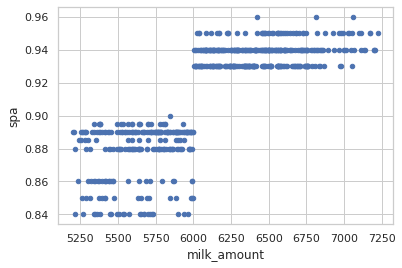

In [31]:
df_ferma_main_edited = df_ferma_main
df_ferma_main_edited.plot.scatter(y='spa', x='milk_amount');

Разделим СПО по границе 0.92

In [32]:
def spa_category(spa_percent):
    if spa_percent <= 0.92:
        return "Малое соотношение"
    else:
        return "Большое соотношение"   

In [33]:
df_ferma_main_edited['spa_category'] = df_ferma_main_edited['spa'].apply(spa_category)
df_ferma_main_edited = df_ferma_main_edited.drop('spa', axis=1)
df_ferma_main_edited

,id,milk_amount,efu,crude_protein,breed,pasture_type,father_breed,current_fat,current_protein,milk_taste,age,spa_category
0,1,5863,14.2,1743,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Малое соотношение
1,2,5529,12.8,2138,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.079,вкусно,менее_2_лет,Малое соотношение
2,3,5810,14.0,1854,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Малое соотношение
3,4,5895,12.4,2012,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Малое соотношение
4,5,5302,12.8,1675,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.073,вкусно,менее_2_лет,Малое соотношение
...,...,...,...,...,...,...,...,...,...,...,...,...
624,625,6812,15.4,1964,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.075,не вкусно,более_2_лет,Большое соотношение
625,626,5513,12.9,1700,РефлешнСоверинг,Равнинное,Соверин,3.64,3.073,вкусно,менее_2_лет,Малое соотношение
626,627,5970,14.4,1837,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет,Малое соотношение
627,628,5746,13.8,1994,РефлешнСоверинг,Равнинное,Соверин,3.64,3.077,вкусно,более_2_лет,Малое соотношение


Было видно, что зависимость удоя от ЭКЕ похожа на график корня, так что стоит добавить новый столбец с квадратом ЭКЕ

In [34]:
df_ferma_main_edited['efu^2'] = df_ferma_main_edited['efu'].apply(lambda x: x**2)
df_ferma_main_edited = df_ferma_main_edited.drop('efu', axis=1)

И снова проведём моделирование

r2 =  0.822107080781098
mae =  155.32018021393122
mse =  41080.038783751304
rmse =  202.68211263885945
95% доверительный интервал r2 : 0.77 - 0.86


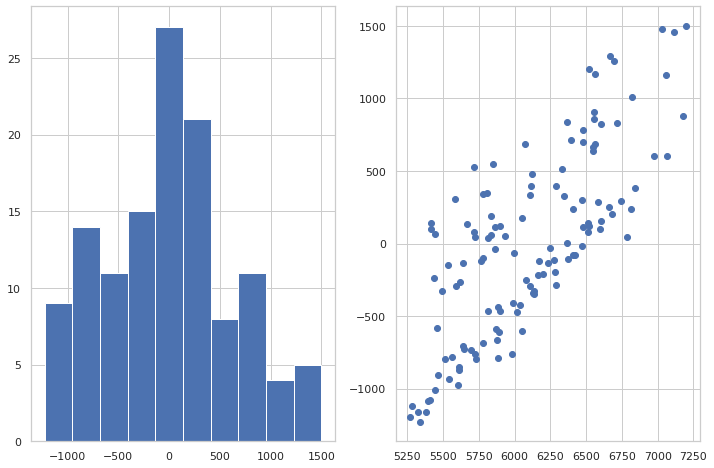

In [35]:
numeric_columns = ['current_protein', 'efu^2', 'crude_protein', 'current_fat']
object_columns = ['breed', 'pasture_type', 'father_breed', 'age', 'spa_category']
scores, regression_model = modeling(df_ferma_main_edited , numeric_columns, object_columns)
models_score.append(scores)

R2 увеличился, распределения остатков стало больше походить на нормальное и дисперсия стала слочайнее, но всё равно пока не идеальна, попробуем добавить имена отцов.

In [36]:
df_ferma_main_edited = df_ferma_main_edited.merge(df_ferma_dad, how='left')

И снова проведём моделирование

r2 =  0.8280903313129387
mae =  149.50136309757417
mse =  39698.35273924681
rmse =  199.24445472646613
95% доверительный интервал r2 : 0.77 - 0.87


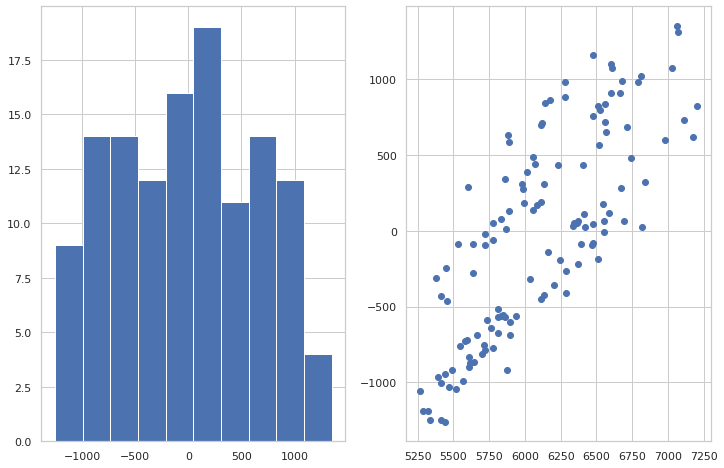

In [37]:
numeric_columns = ['current_protein', 'efu^2', 'crude_protein', 'current_fat']
object_columns = ['breed', 'pasture_type', 'father_breed', 'age', 'spa_category', 'father_name']
scores, regression_model = modeling(df_ferma_main_edited , numeric_columns, object_columns)
models_score.append(scores)

Ещё чуть-чуть повысили r2, но в конце всё-равно остлась закономо=ерность в остатках - на больших удоях модель занижает оценку

In [38]:
df = pd.DataFrame(models_score)
df.columns = ['r2', 'mae', 'mse', 'rmse']
df.index = ['1 модель', '2 модель', '3 модель']
df

,r2,mae,mse,rmse
1 модель,0.794150,173.684575,47535.998809,218.027518
2 модель,0.822107,155.320180,41080.038784,202.682113
3 модель,0.828090,149.501363,39698.352739,199.244455


### Промежуточный вывод по линейной регрессии
Было создано и протестировано 3 модели - наилучший результат показала 3 модель. Для неё мы превратили количественные признаки ЭКЕ, Текущая_жирность,% в категориальные, вместо признака ЭКЕ (Энергетическая кормовая единица) взяли его квадрат и добавили отца коровы в качестве нового признака - в результате мы получили модель r2 лежащем в 95% интервале 0.76-0.87. Я считаю модель справляется со своим предназначением, ведь вы смогли объяснить больше 80% изменчивость целевого признака, но судя по анализу остатков мы можем сказать, что модель может быть улучшена, ведь в них осталась закономерность - модель плохо предсказывает большие удои.

## Задача классификации

Для логистической регрессии воспользуемся теми же данными,что и для 3 модели. Воспользуемся OneHot кодированием для категориальных признаков.

In [39]:
object_columns = ['breed', 'pasture_type', 'father_breed', 'age', 'spa_category', 'father_name']
numeric_columns = ['current_protein', 'efu^2', 'crude_protein', 'current_fat']

# Закодируем предсказываемый признак
df_ferma_main_edited['milk_taste'] = df_ferma_main_edited['milk_taste'].replace({'вкусно' : 1, 'не вкусно' : 0})

# Разделение на тренировочную и тестовую выборки
train_data, test_data = train_test_split(df_ferma_main_edited, test_size=0.2, random_state=40)

# Сброс индексов
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Определение шагов преобразования для ColumnTransformer
transformers = [
    ('numeric', StandardScaler(), numeric_columns),
    ('onehot', OneHotEncoder(drop='if_binary'), object_columns)
]

# Создание ColumnTransformer с определенными шагами
ct = ColumnTransformer(transformers, remainder='passthrough')

# Преобразование тренировочной и тестовой выборок
X_train_transformed = ct.fit_transform(train_data.drop(['milk_amount', 'milk_taste', 'id'], axis=1))
X_test_transformed = ct.transform(test_data.drop(['milk_amount', 'milk_taste', 'id'], axis=1))

# Достаем признаки и целевую переменную для обеих выборок
y_train = train_data['milk_taste']
y_test = test_data['milk_taste']

In [40]:
#Обучим модель логистической регрессии
logistic_model = LogisticRegression()
logistic_model.fit(X_train_transformed, y_train)
#Проверим её на тестовой выборке
predictions = logistic_model.predict(X_test_transformed)

Посмотрим на матрицу ошибок

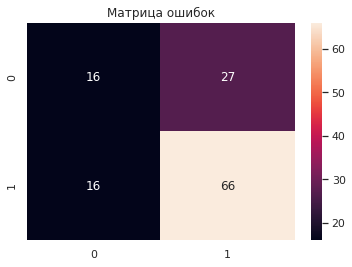

accuracy =  0.656
recall =  0.8048780487804879
precision =  0.7096774193548387


In [41]:
confusion = confusion_matrix(y_test, predictions)
sns.heatmap(confusion, annot=True)
plt.title("Матрица ошибок")
plt.show()
accuracy = accuracy_score(y_test, predictions)
print('accuracy = ', accuracy)
recall = recall_score(y_test, predictions, pos_label=1)
print('recall = ', recall)
precision = precision_score(y_test, predictions, pos_label=1)
print('precision = ', precision)

Так как фермеру необходимо с наибольшеё точностью определить корову со вкусным молоком, то нам стоит максимизировать метрику precision  с помощью повышения порога классификации

In [42]:
# Получаем вероятности классов для тестовых данных
probabilities = logistic_model.predict_proba(X_test_transformed)[:, 1]
y_test = y_test.replace({'вкусно' : 1, 'не вкусно' : 0})
# Подбираем порог
for threshold in np.arange(0.5, 1, 0.01):
    predictions = (probabilities >= threshold).astype(int)
    precision = precision_score(y_test, predictions, pos_label=1)
    print(f"Threshold: {threshold}, Precision: {precision}")
    if precision == 1:
        print("Found threshold achieving precision of 1.")
        print(threshold)
        break

Threshold: 0.5, Precision: 0.7096774193548387
Threshold: 0.51, Precision: 0.7111111111111111
Threshold: 0.52, Precision: 0.7241379310344828
Threshold: 0.53, Precision: 0.7228915662650602
Threshold: 0.54, Precision: 0.7125
Threshold: 0.55, Precision: 0.7105263157894737
Threshold: 0.56, Precision: 0.7297297297297297
Threshold: 0.5700000000000001, Precision: 0.7397260273972602
Threshold: 0.5800000000000001, Precision: 0.7391304347826086
Threshold: 0.5900000000000001, Precision: 0.7352941176470589
Threshold: 0.6000000000000001, Precision: 0.746268656716418
Threshold: 0.6100000000000001, Precision: 0.7868852459016393
Threshold: 0.6200000000000001, Precision: 0.8070175438596491
Threshold: 0.6300000000000001, Precision: 0.8214285714285714
Threshold: 0.6400000000000001, Precision: 0.8269230769230769
Threshold: 0.6500000000000001, Precision: 0.8269230769230769
Threshold: 0.6600000000000001, Precision: 0.8431372549019608
Threshold: 0.6700000000000002, Precision: 0.8666666666666667
Threshold: 0.6

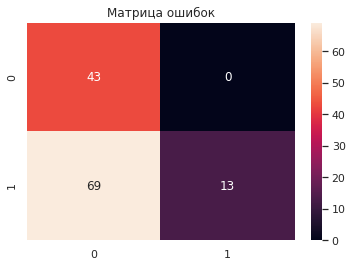

In [43]:
confusion = confusion_matrix(y_test, predictions)
sns.heatmap(confusion, annot=True)
plt.title("Матрица ошибок")
plt.show()

### Промежуточный вывод по логистической регрессии
Была создана модель логистической регрессии для определения вкуса молока с accuracy 0.65. Так как фермеру необходимо с наибольшеё точностью определить корову со вкусным молоком, то был произведён подбор такого порога классификации, что метрика precision стала 1, такой порог - 0.79

## Отбор коров

Подготовим датасет с коровами для покупки. Сначала добавим информацию о корме

In [44]:
df_cow_buy['crude_protein'] = df_ferma_main['crude_protein'].mean() * 1.05
df_cow_buy['efu'] = df_ferma_main['efu'].mean() * 1.05
df_cow_buy['spa'] = df_ferma_main['spa'].mean() * 1.05
df_cow_buy

,breed,pasture_type,father_breed,father_name,current_fat,current_protein,age,crude_protein,efu,spa
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.77191,15.276742,0.958947
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,2019.77191,15.276742,0.958947
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,2019.77191,15.276742,0.958947
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,2019.77191,15.276742,0.958947
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,2019.77191,15.276742,0.958947
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,2019.77191,15.276742,0.958947
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,2019.77191,15.276742,0.958947
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,2019.77191,15.276742,0.958947
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,2019.77191,15.276742,0.958947
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,2019.77191,15.276742,0.958947


Теперь проведём те же преобразования, что и для 3 модели

In [45]:
df_cow_buy_edited = df_cow_buy
df_cow_buy_edited['spa_category'] = df_cow_buy_edited['spa'].apply(spa_category)
df_cow_buy_edited = df_cow_buy_edited.drop('spa', axis=1)
df_cow_buy_edited['efu^2'] = df_cow_buy_edited['efu'].apply(lambda x: x**2)
df_cow_buy_edited = df_cow_buy_edited.drop('efu', axis=1)
df_cow_buy_edited = df_cow_buy_edited .reset_index(drop=True)

Закодируем категориальные признаки

In [46]:
object_columns = ['breed', 'pasture_type', 'father_breed', 'age', 'spa_category', 'father_name']
numeric_columns = ['current_protein', 'efu^2', 'crude_protein', 'current_fat']

# Определение шагов преобразования для ColumnTransformer
transformers = [
    ('numeric', StandardScaler(), numeric_columns),
    ('onehot', OneHotEncoder(drop='if_binary'), object_columns)
]

# Создание ColumnTransformer с определенными шагами
ct = ColumnTransformer(transformers, remainder='passthrough')
# Преобразование тренировочной и тестовой выборок
X_test = ct.fit_transform(df_cow_buy_edited)

Используем модели для предсказания количества удоя и вкуса молока

In [47]:
amount_predictions = regression_model.predict(X_test)
probabilities = logistic_model.predict_proba(X_test)[:, 1]
taste_predictions = (probabilities >= 0.79).astype(int)

In [48]:
df_cow_buy['milk_count'] = amount_predictions
df_cow_buy['milk_taste'] = taste_predictions
df_cow_buy[(df_cow_buy['milk_count'] > 6000) & (df_cow_buy['milk_taste'] == 1)]

,breed,pasture_type,father_breed,father_name,current_fat,current_protein,age,crude_protein,efu,spa,spa_category,milk_count,milk_taste
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,2019.77191,15.276742,0.958947,Большое соотношение,6123.577742,1


Судя по использованным нами моделям фермер с минимальным риском для себя может купить 1 корову из списка - 1 по счёту

## Общий вывод
В ходе работы юыла проведена предобработка данных, исследовательский и корреляционный анализ, постороена модели линейной и логистической регрессии, а также подобраны коровы для покупки.
* В ходе предобработки было рассмотрено 3 файла с данными, датасет с папами коров мы никак не изменили, в таблици с информацией о коровах на продажу было удалено 4 явных дубликата и в датасете с коровами фермера мы заменили неявные дубликаты и удалили около 1% выбросов.
* Как показал исследовательский анализ данных распределение большинства числовых признаков примерно похоже на нормальное, только графики spa и current_fat - мультимодальные и именно поэтому в дальнейшей обработке мы заменили тип этих признаков на категориальный. Все категориальные признаки распределены примерно поровну, единственное исключение - возраст, в исследуемых данных большинство коров старше 2 лет.

* Исследовав корреляцию между признаками мы видим, что хоть и некая линейная взаимосвязь между целевым признаком и некоторыми зависимыми признаками присутствует, но судя по графикам чёткой линейной зависимости нет. Также видно пару любопытных особенностей: между efu и milk_amount есть чёткая связь, хоть и не линейная, количество молока от старых коров всегда больше, чем от молодых и порода Айдиал даёт больший удой чем Соверин. Признаки Current fat и spa оба разделились на 3 кластера, что помогает в их преобразовании в категориальные. Также была найдена мультиколлинеарность между входными признаками - current_fat, etu и spa сильно связаны между собой.


* В ходе работы было создано и протестировано 3 модели линейной регрессии - наилучший результат показала 3 модель -
    *  r2 = 0.828090
    * mae =  149.501363
    * mse =  39698.352739
    * rmse =  199.244455
			
    Для неё мы превратили количественные признаки ЭКЕ, Текущая_жирность,% в категориальные, вместо признака ЭКЕ (Энергетическая кормовая единица) взяли его квадрат и добавили отца коровы в качестве нового признака - в результате мы получили модель r2 лежащем в 95% интервале 0.76-0.87. Я считаю модель справляется со своим предназначением, ведь вы смогли объяснить больше 80% изменчивость целевого признака, но судя по анализу остатков мы можем сказать, что модель может быть улучшена, ведь в них осталась закономерность - модель плохо предсказывает большие удои.

* Была создана модель логистической регрессии для определения вкуса молока с accuracy 0.66. Так как фермеру необходимо с наибольшеё точностью определить корову со вкусным молоком, то был произведён подбор такого порога классификации, что метрика precision стала 1, такой порог - 0.79

В конце работы мы обработали данные по коровам на продажу для подачи в модели и далее спрогнозировали вероятные значения удоя и вкуса молока. Было выяснено, что с минимальным риском фермер может купить одну корову под номером 1, для большего количества коров, но с меньшей точностью стоит понизить порог классификации. Для будущего использования моделей советуется набрать информации о коровах с большим удоеем, ведь текущая модель слаба в этой области.